In [3]:
import pandas as pd

### Annotate final peaks

In [4]:
feature_colors={'exon': '#f4d03f',
 'five_prime_utr': '#a569bd',
 'intergenic': '#eb984e',
 'intron': '#aab7b8',
 'promoter': '#48c9b0',
 'stop_codon': '#5499c7',
 'three_prime_utr': '#566573', 
                'start_codon':'#cb4335'}

In [23]:
# List of peaks after merge (cluster ATAC_integration_merged_peaks_with_CNA_correction.ipynb)
peaks_final=pd.read_csv('/Users/alexandra.livanova/Downloads/diff_peaksDec.csv', )
peaks_final

,feature name,log2(fold_change),p-value,adjusted p-value
0,chrX:1392003-1392504,-8.924105,2.246933e-137,1.919645e-132
1,chrX:1452985-1453486,-5.176526,1.103116e-126,4.712179e-122
2,chrX:318725-319226,-4.895583,8.041728e-126,2.290123e-121
3,chrX:1408578-1409079,2.165921,2.751119e-95,5.875977e-91
4,chrX:335285-335786,1.967257,2.888176e-91,4.934969e-87
...,...,...,...,...
85429,chr17:17709455-17709956,0.333414,1.000000e+00,1.000000e+00
85430,chr18:34697126-34697627,0.276487,1.000000e+00,1.000000e+00
85431,chr19:39198988-39199489,0.259184,1.000000e+00,1.000000e+00
85432,chr2:59804799-59805300,-0.348178,1.000000e+00,1.000000e+00


In [8]:
peaks_final[['chromosome', 'range']] = peaks_final['feature name'].str.split(':', expand=True)
peaks_final[['start', 'end']] = peaks_final['range'].str.split('-', expand=True)
peaks_final.drop(columns=['range'], inplace=True)
peaks_final['start'] = peaks_final['start'].astype(int)
peaks_final['end'] = peaks_final['end'].astype(int)

peaks_final = peaks_final[['chromosome', 'start', 'end']]
peaks_final['peak']=peaks_final['chromosome'].astype('str')+ ':' +peaks_final['start'].astype('str') + '-' + peaks_final['end'].astype('str')
peaks_final

/var/folders/mk/9hzfb0wd5w1fctlgjfv6lqx80000gp/T/ipykernel_58245/417300737.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_final['peak']=peaks_final['chromosome'].astype('str')+ ':' +peaks_final['start'].astype('str') + '-' + peaks_final['end'].astype('str')


,chromosome,start,end,peak
0,chrX,1392003,1392504,chrX:1392003-1392504
1,chrX,1452985,1453486,chrX:1452985-1453486
2,chrX,318725,319226,chrX:318725-319226
3,chrX,1408578,1409079,chrX:1408578-1409079
4,chrX,335285,335786,chrX:335285-335786
...,...,...,...,...
85429,chr17,17709455,17709956,chr17:17709455-17709956
85430,chr18,34697126,34697627,chr18:34697126-34697627
85431,chr19,39198988,39199489,chr19:39198988-39199489
85432,chr2,59804799,59805300,chr2:59804799-59805300


In [9]:
#save bed file with peaks
peaks_final.to_csv('/Users/alexandra.livanova/Downloads/diff_peaksDec.bed', sep="\t", header=False, index=False)

In [10]:
# process peaks annotated with all features data
peaks_anno=pd.read_csv('/Users/alexandra.livanova/Downloads/diff_peaksDec_genes_annotated.bed', sep='\t', header=None)

peaks_anno['peak']=peaks_anno[0].astype('str')+ ':' +peaks_anno[1].astype('str') + '-' + peaks_anno[2].astype('str')

peaks_anno.drop([0, 1, 2, 3, 4, 5, 7, 8, 9, 11, 12, 13], inplace=True, axis=1)

In [11]:
peaks_anno=peaks_anno.drop_duplicates()
peaks_anno


,6,10,14,peak
0,1392103,transcript,SLC25A6,chrX:1392003-1392504
1,1392088,transcript,SLC25A6,chrX:1392003-1392504
2,1392009,CDS,SLC25A6,chrX:1392003-1392504
3,1392088,exon,SLC25A6,chrX:1392003-1392504
4,1392103,exon,SLC25A6,chrX:1392003-1392504
...,...,...,...,...
501668,34891398,transcript,DTNA,chr18:34697126-34697627
501669,39201884,transcript,NCCRP1,chr19:39198988-39199489
501670,39199265,CDS,NCCRP1,chr19:39198988-39199489
501671,39199265,exon,NCCRP1,chr19:39198988-39199489


In [12]:
peaks_anno = peaks_anno[peaks_anno[10] != "CDS"]

# 2. Group by peak and aggregate features into a set
grouped = peaks_anno.groupby("peak")[10].apply(set).reset_index()

# 3. Define function to assign final label
def assign_label(features):
    if "five_prime_utr" in features:
        return "five_prime_utr"
    elif "three_prime_utr" in features:
        return "three_prime_utr"
    elif "start_codon" in features:
        return "start_codon"
    elif "stop_codon" in features:
        return "stop_codon"
    elif "exon" in features:
        return "exon"
    elif "transcript" in features:
        return "intron"
    else:
        return "unknown"

# 4. Apply function
grouped["final_label"] = grouped[10].apply(assign_label)

# Final result: one row per peak
final_df = grouped[["peak", "final_label"]]

In [13]:
final_df['final_label'].value_counts()

final_label
intron             37700
five_prime_utr     11513
exon                9021
three_prime_utr     3741
start_codon           98
stop_codon            20
Name: count, dtype: int64

In [14]:
#process annotated promoters
promoters_anno=pd.read_csv('/Users/alexandra.livanova/Downloads/diff_peaksDec_promoteres_annotated.bed', sep='\t', header=None)
promoters_anno


,0,1,2,3,4,5,6,7
0,chrX,1392003,1392504,chrX:1392003-1392504,chrX,1392224,1393724,SLC25A6
1,chrX,1452985,1453486,chrX:1452985-1453486,chrX,1453262,1454762,ASMTL
2,chrX,1452985,1453486,chrX:1452985-1453486,chrX,1452373,1453873,ASMTL
3,chrX,1452985,1453486,chrX:1452985-1453486,chrX,1452429,1453929,ASMTL
4,chrX,318725,319226,chrX:318725-319226,chrX,318319,319819,GTPBP6
...,...,...,...,...,...,...,...,...
47078,chr7,143885151,143885652,chr7:143885151-143885652,chr7,143884870,143886370,TCAF1
47079,chr19,18281583,18282084,chr19:18281583-18282084,chr19,18281122,18282622,JUND
47080,chr19,18281583,18282084,chr19:18281583-18282084,chr19,18280429,18281929,JUND
47081,chr2,219218748,219219249,chr2:219218748-219219249,chr2,219218490,219219990,ABCB6


In [15]:
promoters_anno['peak']=promoters_anno[0].astype('str')+ ':' +promoters_anno[1].astype('str') + '-' + promoters_anno[2].astype('str')
promoters_anno

,0,1,2,3,4,5,6,7,peak
0,chrX,1392003,1392504,chrX:1392003-1392504,chrX,1392224,1393724,SLC25A6,chrX:1392003-1392504
1,chrX,1452985,1453486,chrX:1452985-1453486,chrX,1453262,1454762,ASMTL,chrX:1452985-1453486
2,chrX,1452985,1453486,chrX:1452985-1453486,chrX,1452373,1453873,ASMTL,chrX:1452985-1453486
3,chrX,1452985,1453486,chrX:1452985-1453486,chrX,1452429,1453929,ASMTL,chrX:1452985-1453486
4,chrX,318725,319226,chrX:318725-319226,chrX,318319,319819,GTPBP6,chrX:318725-319226
...,...,...,...,...,...,...,...,...,...
47078,chr7,143885151,143885652,chr7:143885151-143885652,chr7,143884870,143886370,TCAF1,chr7:143885151-143885652
47079,chr19,18281583,18282084,chr19:18281583-18282084,chr19,18281122,18282622,JUND,chr19:18281583-18282084
47080,chr19,18281583,18282084,chr19:18281583-18282084,chr19,18280429,18281929,JUND,chr19:18281583-18282084
47081,chr2,219218748,219219249,chr2:219218748-219219249,chr2,219218490,219219990,ABCB6,chr2:219218748-219219249


In [16]:
promoters_anno.drop([0, 1, 2, 3, 4, 5, 6, 7], inplace=True, axis=1)
promoters_anno.drop_duplicates(inplace=True)
promoters_anno

,peak
0,chrX:1392003-1392504
1,chrX:1452985-1453486
4,chrX:318725-319226
5,chrX:41084387-41084888
7,chrX:154378896-154379397
...,...
47076,chr12:47801518-47802019
47077,chr6:138499353-138499854
47078,chr7:143885151-143885652
47079,chr19:18281583-18282084


In [17]:
#Add annotations of promoters
promoter_peaks = set(promoters_anno['peak'])
final_df.loc[final_df['peak'].isin(promoter_peaks), 'final_label'] = 'promoter'

existing_peaks = set(final_df['peak'])
missing_promoter_peaks = promoter_peaks - existing_peaks

missing_rows = promoters_anno[promoters_anno['peak'].isin(missing_promoter_peaks)].copy()
missing_rows['final_label'] = 'promoter'

columns_to_use = ['peak', 'final_label']  # extend if needed
missing_rows = missing_rows[columns_to_use]

final_df = pd.concat([final_df, missing_rows], ignore_index=True)
final_df

,peak,final_label
0,chr10:100006253-100006754,intron
1,chr10:100009750-100010251,promoter
2,chr10:100045962-100046463,intron
3,chr10:100185823-100186324,promoter
4,chr10:100286452-100286953,promoter
...,...,...
62950,chr22:27801587-27802088,promoter
62951,chr19:55407942-55408443,promoter
62952,chr20:9067555-9068056,promoter
62953,chr19:35290709-35291210,promoter


In [18]:
final_df['final_label'].value_counts()

final_label
intron             35900
promoter           15398
exon                7590
three_prime_utr     3473
five_prime_utr       573
stop_codon            13
start_codon            8
Name: count, dtype: int64

In [19]:
# Add unannotated peaks as intergenic (as soon as they were not identified as any gene feature)
final_peaks = set(final_df['peak'])
all_peaks = set(peaks_final['peak'])

missing_peaks = all_peaks - final_peaks

intergenic_df = peaks_final[peaks_final['peak'].isin(missing_peaks)].copy()
intergenic_df['final_label'] = 'intergenic'

intergenic_df = intergenic_df[['peak', 'final_label']]

final_df = pd.concat([final_df, intergenic_df], ignore_index=True)
final_df

,peak,final_label
0,chr10:100006253-100006754,intron
1,chr10:100009750-100010251,promoter
2,chr10:100045962-100046463,intron
3,chr10:100185823-100186324,promoter
4,chr10:100286452-100286953,promoter
...,...,...
85429,chr3:50515564-50516065,intergenic
85430,chr6:137233878-137234379,intergenic
85431,chr7:128425733-128426234,intergenic
85432,chr11:119742126-119742627,intergenic


In [24]:
final_df

,peak,final_label
0,chr10:100006253-100006754,intron
1,chr10:100009750-100010251,promoter
2,chr10:100045962-100046463,intron
3,chr10:100185823-100186324,promoter
4,chr10:100286452-100286953,promoter
...,...,...
85429,chr3:50515564-50516065,intergenic
85430,chr6:137233878-137234379,intergenic
85431,chr7:128425733-128426234,intergenic
85432,chr11:119742126-119742627,intergenic


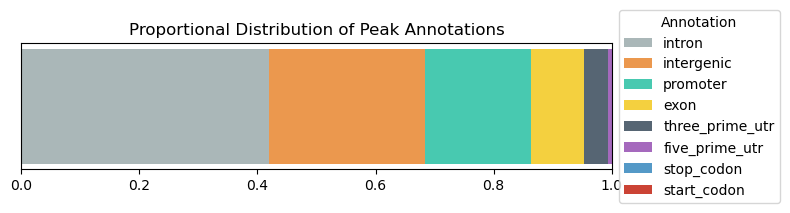

In [34]:
import matplotlib.pyplot as plt
import pandas as pd

# Count and proportions
label_counts = final_df['final_label'].value_counts()
total = label_counts.sum()
label_props = label_counts / total

# Colors in the order of label_props keys
colors = [feature_colors.get(label, '#333333') for label in label_props.index]

# Plot
fig, ax = plt.subplots(figsize=(8, 2))

left = 0
for label, prop in label_props.items():
    ax.barh(
        0, 
        width=prop, 
        left=left, 
        color=feature_colors.get(label, '#333333'), 
        label=label
    )
    left += prop

# Formatting
ax.set_xlim(0, 1)
ax.set_yticks([])
ax.set_title('Proportional Distribution of Peak Annotations')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Annotation')
plt.tight_layout()
plt.show()


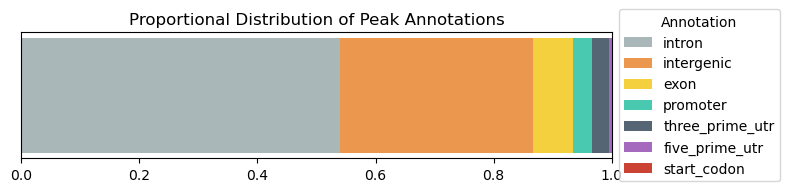

In [35]:
final_df_peri=final_df[final_df['peak'].isin(peaks_final[(peaks_final['log2(fold_change)']>1) & (peaks_final['adjusted p-value']<0.01)]['feature name'].tolist())]
final_df_core=final_df[final_df['peak'].isin(peaks_final[(peaks_final['log2(fold_change)']<-1) & (peaks_final['adjusted p-value']<0.01)]['feature name'].tolist())]

# Count and proportions
label_counts = final_df_peri['final_label'].value_counts()
total = label_counts.sum()
label_props = label_counts / total

# Colors in the order of label_props keys
colors = [feature_colors.get(label, '#333333') for label in label_props.index]

# Plot
fig, ax = plt.subplots(figsize=(8, 2))

left = 0
for label, prop in label_props.items():
    ax.barh(
        0, 
        width=prop, 
        left=left, 
        color=feature_colors.get(label, '#333333'), 
        label=label
    )
    left += prop

# Formatting
ax.set_xlim(0, 1)
ax.set_yticks([])
ax.set_title('Proportional Distribution of Peak Annotations')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Annotation')
plt.tight_layout()
plt.show()


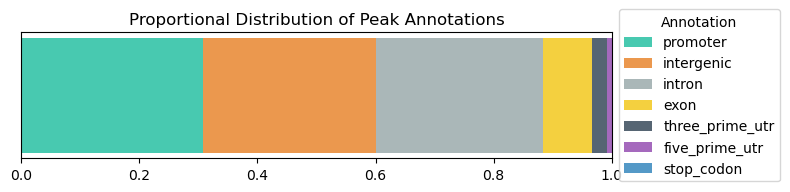

In [36]:
import matplotlib.pyplot as plt
import pandas as pd

# Count and proportions
label_counts = final_df_core['final_label'].value_counts()
total = label_counts.sum()
label_props = label_counts / total

# Colors in the order of label_props keys
colors = [feature_colors.get(label, '#333333') for label in label_props.index]

# Plot
fig, ax = plt.subplots(figsize=(8, 2))

left = 0
for label, prop in label_props.items():
    ax.barh(
        0, 
        width=prop, 
        left=left, 
        color=feature_colors.get(label, '#333333'), 
        label=label
    )
    left += prop

# Formatting
ax.set_xlim(0, 1)
ax.set_yticks([])
ax.set_title('Proportional Distribution of Peak Annotations')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Annotation')
plt.tight_layout()
plt.show()


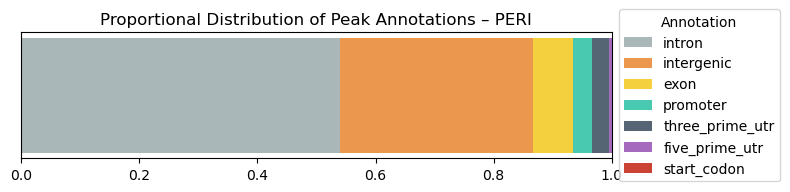

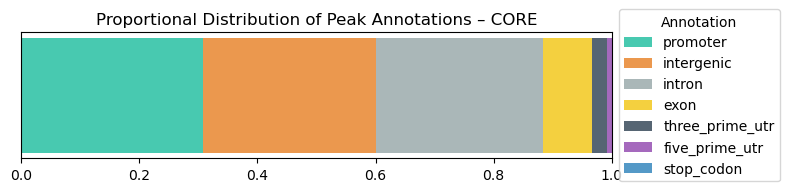

In [37]:
# --- Subsets ---
final_df_peri = final_df[
    final_df['peak'].isin(
        peaks_final[
            (peaks_final['log2(fold_change)'] > 1) &
            (peaks_final['adjusted p-value'] < 0.01)
        ]['feature name'].tolist()
    )
]

final_df_core = final_df[
    final_df['peak'].isin(
        peaks_final[
            (peaks_final['log2(fold_change)'] < -1) &
            (peaks_final['adjusted p-value'] < 0.01)
        ]['feature name'].tolist()
    )
]

# --- Function to plot stacked bar ---
def plot_stacked_bar(df, title):
    label_counts = df['final_label'].value_counts()
    total = label_counts.sum()
    label_props = label_counts / total

    fig, ax = plt.subplots(figsize=(8, 2))

    left = 0
    for label, prop in label_props.items():
        ax.barh(
            0,
            width=prop,
            left=left,
            color=feature_colors.get(label, '#333333'),
            label=label
        )
        left += prop

    ax.set_xlim(0, 1)
    ax.set_yticks([])
    ax.set_title(title)
    ax.legend(
        loc='center left',
        bbox_to_anchor=(1, 0.5),
        title='Annotation'
    )
    plt.tight_layout()
    plt.show()

# --- Plot peri ---
plot_stacked_bar(final_df_peri, "Proportional Distribution of Peak Annotations – PERI")

# --- Plot core ---
plot_stacked_bar(final_df_core, "Proportional Distribution of Peak Annotations – CORE")


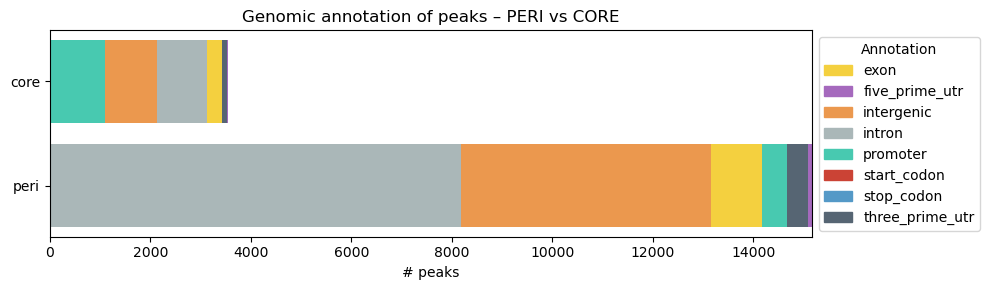

In [42]:
# --- Subsets ---
final_df_peri = final_df[
    final_df['peak'].isin(
        peaks_final[
            (peaks_final['log2(fold_change)'] > 1) &
            (peaks_final['adjusted p-value'] < 0.01)
        ]['feature name'].tolist()
    )
]

final_df_core = final_df[
    final_df['peak'].isin(
        peaks_final[
            (peaks_final['log2(fold_change)'] < -1) &
            (peaks_final['adjusted p-value'] < 0.01)
        ]['feature name'].tolist()
    )
]

# Counts
counts_peri = final_df_peri['final_label'].value_counts()
counts_core = final_df_core['final_label'].value_counts()

# Determine a shared x-axis max
max_val = max(counts_peri.sum(), counts_core.sum())


# --- Plot two stacked bars with shared scale ---
fig, ax = plt.subplots(figsize=(10, 3))

# PERI bar
left = 0
for label, count in counts_peri.items():
    ax.barh(
        y="peri",
        width=count,
        left=left,
        color=feature_colors.get(label, "#333333"),
    )
    left += count

# CORE bar
left = 0
for label, count in counts_core.items():
    ax.barh(
        y="core",
        width=count,
        left=left,
        color=feature_colors.get(label, "#333333"),
    )
    left += count

ax.set_xlim(0, max_val)
ax.set_xlabel("# peaks")
ax.set_title("Genomic annotation of peaks – PERI vs CORE")

# Build legend only once
unique_labels = list(counts_peri.index.union(counts_core.index))
handles = [plt.Rectangle((0,0),1,1, color=feature_colors.get(lbl, "#333333"))
           for lbl in unique_labels]
ax.legend(handles, unique_labels, title="Annotation", bbox_to_anchor=(1, 1), loc="upper left")

plt.tight_layout()
plt.show()
